<a href="https://colab.research.google.com/github/chinmayeeadiga/emotion-detection/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EMOTION DETECTION BY TEXT**

Number of emotion classes : 6

Types of emotion classes :
*   Sadness
*   Joy
*   Love
*   Anger
*   Fear
*   Surprise

Dataset Used : Emotion Dataset by dair-ai

Models Used : Logisic Regression and CNN

In [ ]:
#importing dependencies
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
#loading the dataset
splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
X_train = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["train"])
X_val = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["validation"])
X_test = pd.read_parquet("hf://datasets/dair-ai/emotion/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# cleaning the data
!pip install wordcloud emoji
import re
import emoji
import string
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+", '', text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words and word.isalpha()]
    return " ".join(tokens)

X_train['clean_text'] = X_train['text'].apply(preprocess)
X_test['clean_text'] = X_test['text'].apply(preprocess)
X_val['clean_text'] = X_val['text'].apply(preprocess)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
# getting the data ready
y_train = X_train['label']
y_test = X_test['label']
y_val = X_val['label']

X_train = X_train[['clean_text']]
X_train.columns = ['clean_text']
X_test = X_test[['clean_text']]
X_test.columns = ['clean_text']
X_val = X_val[['clean_text']]
X_val.columns = ['clean_text']

/tmp/ipython-input-5-658360236.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Set2')


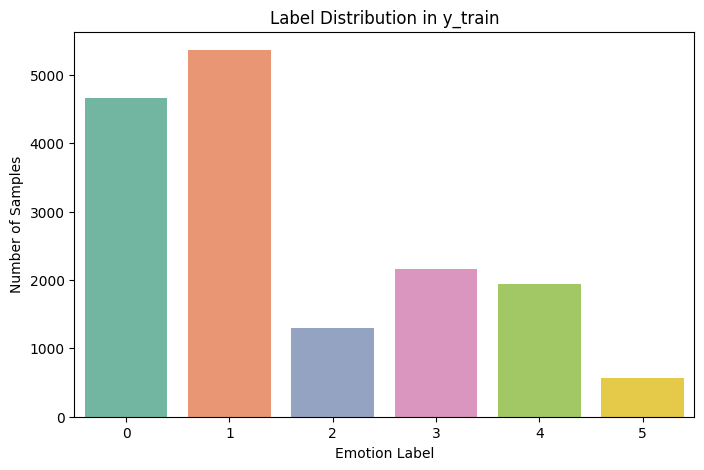

In [ ]:
#bar plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=y_train, palette='Set2')
plt.title("Label Distribution in y_train")
plt.xlabel("Emotion Label")
plt.ylabel("Number of Samples")
plt.show()

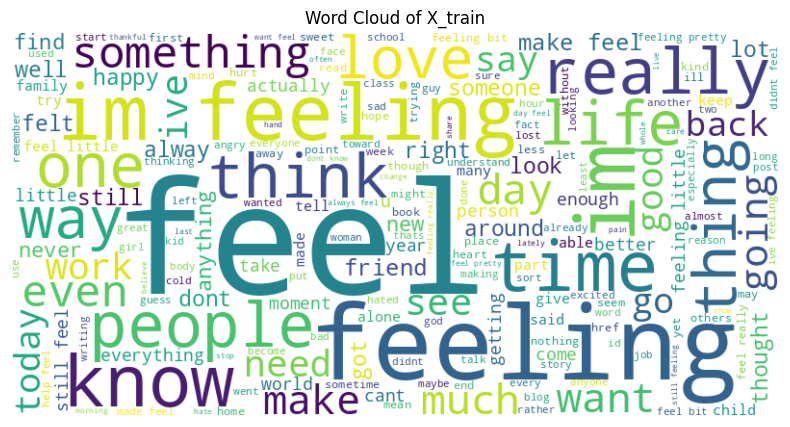

In [ ]:
#word clouds
from wordcloud import WordCloud

text = " ".join(X_train['clean_text'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of X_train")
plt.show()

**WORD EMBEDDINGS**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-07-11 05:01:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-07-11 05:01:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-07-11 05:01:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
#Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train['clean_text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_val_seq = tokenizer.texts_to_sequences(X_val['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

In [ ]:
#Padding
max_len = max(len(seq) for seq in X_train_seq)
X_train = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [ ]:
#Load GloVe Embeddings
embedding_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

In [ ]:
#Create Embedding Matrix
embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**LOGISTIC REGRESSION**

In [ ]:
#training the model
lr_model = LogisticRegression(max_iter=2000, multi_class='multinomial', solver='lbfgs')
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000, multi_class='multinomial')

In [ ]:
# evaluating the model
y_pred = lr_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.3455
Precision: 0.1001
Recall:    0.1668
F1 Score:  0.0970

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.04      0.07       581
           1       0.35      0.96      0.51       695
           2       0.00      0.00      0.00       159
           3       0.00      0.00      0.00       275
           4       0.00      0.00      0.00       224
           5       0.00      0.00      0.00        66

    accuracy                           0.35      2000
   macro avg       0.10      0.17      0.10      2000
weighted avg       0.19      0.35      0.20      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**CNN MODELS**

In [ ]:
#Prepare labels (convert to categorical)
num_classes = y_train.nunique()
y_train_new = to_categorical(y_train, num_classes=num_classes)
y_val_new = to_categorical(y_val, num_classes=num_classes)
y_test_new = to_categorical(y_test, num_classes=num_classes)

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Input layer
input_layer = Input(shape=(max_len,))

# Embedding layer
embedding_layer = Embedding(input_dim=num_words,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)(input_layer)

# Convolutional layers with different kernel sizes
conv_3 = Conv1D(128, kernel_size=3, activation='relu')(embedding_layer)
conv_3 = BatchNormalization()(conv_3)
pool_3 = GlobalMaxPooling1D()(conv_3)

conv_4 = Conv1D(128, kernel_size=4, activation='relu')(embedding_layer)
conv_4 = BatchNormalization()(conv_4)
pool_4 = GlobalMaxPooling1D()(conv_4)

conv_5 = Conv1D(128, kernel_size=5, activation='relu')(embedding_layer)
conv_5 = BatchNormalization()(conv_5)
pool_5 = GlobalMaxPooling1D()(conv_5)

# Merge pooled outputs
merged = Concatenate()([pool_3, pool_4, pool_5])

# Dropout and Dense layers
dropout = Dropout(0.5)(merged)
dense = Dense(128, activation='relu')(dropout)
output = Dense(num_classes, activation='softmax')(dense)

# Build and compile model
model = Model(inputs=input_layer, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 100)   │  1,348,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 33, 128)   │     38,528 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 32, 128)   │     51,328 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 31, 128)   │     64,128 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 33, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │        774 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,553,774 (5.93 MB)

 Trainable params: 204,806 (800.02 KB)

 Non-trainable params: 1,348,968 (5.15 MB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss')

# Fit the model
history = model.fit(X_train, y_train_new,
                    epochs=15,
                    batch_size=32,
                    validation_data=(X_val, y_val_new),
                    callbacks=[early_stop, checkpoint])


Epoch 1/15
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8677 - loss: 0.3652

500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.8677 - loss: 0.3653 - val_accuracy: 0.8655 - val_loss: 0.3590
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8760 - loss: 0.3336

500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8760 - loss: 0.3336 - val_accuracy: 0.8745 - val_loss: 0.3405
Epoch 3/15
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8874 - loss: 0.3064

500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.8874 - loss: 0.3065 - val_accuracy: 0.8755 - val_loss: 0.3347
Epoch 4/15
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8964 - loss: 0.2867

500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.8964 - loss: 0.2868 - val_accuracy: 0.8820 - val_loss: 0.3232
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.9027 - loss: 0.2684 - val_accuracy: 0.8800 - val_loss: 0.3308
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9103 - loss: 0.2550 - val_accuracy: 0.8845 - val_loss: 0.3338
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9107 - loss: 0.2366 - val_accuracy: 0.8740 - val_loss: 0.3477


In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_new, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
# evaluating the model
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Accuracy: 0.8745
Precision: 0.8414
Recall:    0.8165
F1 Score:  0.8277

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       581
           1       0.90      0.89      0.90       695
           2       0.74      0.72      0.73       159
           3       0.90      0.89      0.90       275
           4       0.87      0.85      0.86       224
           5       0.76      0.62      0.68        66

    accuracy                           0.87      2000
   macro avg       0.84      0.82      0.83      2000
weighted avg       0.87      0.87      0.87      2000



In [ ]:
import pickle

model.save('model.h5')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

from google.colab import files
files.download("model.h5")

from google.colab import files
files.download("tokenizer.pkl")

from google.colab import files
files.download("label_encoder.pkl")

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
max_len = 100  # use the same max_len used for model training

def preprocess_text(text):
    text = text.lower()
    text = emoji.demojize(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

import gradio as gr
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder and fit it to the original training labels
label_encoder = LabelEncoder()
# Access the original integer labels before one-hot encoding
label_encoder.fit(y_train)

def predict_emotion(text):
    cleaned = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding="post")
    pred = model.predict(padded)[0]
    threshold = 0.3

    top_indices = np.where(pred > threshold)[0]
    if len(top_indices) == 0:
        return "Neutral"

    emotions = [str(e) for e in label_encoder.classes_[top_indices]]
    return ", ".join(emotions)


In [ ]:
import ipywidgets as widgets
from IPython.display import display

input_box = widgets.Textarea(placeholder='Enter text here', layout=widgets.Layout(width='100%', height='100px'))
output_box = widgets.Output()
button = widgets.Button(description='Detect Emotion')

def on_click(b):
    output_box.clear_output()
    text = input_box.value
    with output_box:
        print(predict_emotion(text))

button.on_click(on_click)

display(input_box, button, output_box)


Textarea(value='', layout=Layout(height='100px', width='100%'), placeholder='Enter text here')

Button(description='Detect Emotion', style=ButtonStyle())

Output()